In [13]:
import pandas as pd
import numpy as np
import os

In [14]:
# Set to True to force a full refresh of the data
full_refresh = True

In [15]:
repo_root = os.popen('git rev-parse --show-toplevel').read().strip()

In [16]:
data_folder = os.path.join(repo_root, 'multi-parameter-estimation', 'data')

# Get list of data directories
data_dirs = os.listdir(data_folder)
data_dirs = [d for d in data_dirs if os.path.isdir(os.path.join(data_folder, d))]

# skip old-data
if 'old-data' in data_dirs:
    data_dirs.remove('old-data')

data_dirs.sort()
data_dirs

['2025-06-03--11h-02m-55s',
 '2025-06-03--11h-04m-33s',
 '2025-06-03--11h-05m-58s',
 '2025-06-03--11h-07m-21s',
 '2025-06-03--11h-08m-43s',
 '2025-06-03--11h-10m-06s',
 '2025-06-03--11h-11m-30s',
 '2025-06-03--11h-12m-54s',
 '2025-06-03--11h-14m-20s',
 '2025-06-03--11h-15m-44s',
 '2025-06-03--11h-17m-10s',
 '2025-06-03--11h-18m-35s',
 '2025-06-03--11h-20m-00s',
 '2025-06-03--11h-21m-24s',
 '2025-06-03--11h-22m-50s',
 '2025-06-03--11h-24m-16s',
 '2025-06-03--11h-25m-44s',
 '2025-06-03--11h-27m-10s',
 '2025-06-03--11h-28m-52s',
 '2025-06-03--11h-30m-17s',
 '2025-06-03--11h-31m-43s',
 '2025-06-03--11h-33m-09s',
 '2025-06-03--11h-34m-37s',
 '2025-06-03--11h-36m-03s',
 '2025-06-03--11h-37m-30s',
 '2025-06-03--11h-38m-56s',
 '2025-06-03--11h-40m-23s',
 '2025-06-03--11h-41m-53s',
 '2025-06-03--11h-43m-21s',
 '2025-06-03--11h-44m-49s',
 '2025-06-03--11h-46m-15s',
 '2025-06-03--11h-47m-43s',
 '2025-06-03--11h-49m-09s',
 '2025-06-03--11h-50m-33s',
 '2025-06-03--11h-51m-57s',
 '2025-06-03--11h-53

In [17]:
new_data_dirs = data_dirs.copy()

if not full_refresh:
    for d in data_dirs:
        if os.path.exists(os.path.join(data_folder, d, "chunked_coincidences_n=40.csv")):
            new_data_dirs.remove(d)

new_data_dirs

['2025-06-03--11h-02m-55s',
 '2025-06-03--11h-04m-33s',
 '2025-06-03--11h-05m-58s',
 '2025-06-03--11h-07m-21s',
 '2025-06-03--11h-08m-43s',
 '2025-06-03--11h-10m-06s',
 '2025-06-03--11h-11m-30s',
 '2025-06-03--11h-12m-54s',
 '2025-06-03--11h-14m-20s',
 '2025-06-03--11h-15m-44s',
 '2025-06-03--11h-17m-10s',
 '2025-06-03--11h-18m-35s',
 '2025-06-03--11h-20m-00s',
 '2025-06-03--11h-21m-24s',
 '2025-06-03--11h-22m-50s',
 '2025-06-03--11h-24m-16s',
 '2025-06-03--11h-25m-44s',
 '2025-06-03--11h-27m-10s',
 '2025-06-03--11h-28m-52s',
 '2025-06-03--11h-30m-17s',
 '2025-06-03--11h-31m-43s',
 '2025-06-03--11h-33m-09s',
 '2025-06-03--11h-34m-37s',
 '2025-06-03--11h-36m-03s',
 '2025-06-03--11h-37m-30s',
 '2025-06-03--11h-38m-56s',
 '2025-06-03--11h-40m-23s',
 '2025-06-03--11h-41m-53s',
 '2025-06-03--11h-43m-21s',
 '2025-06-03--11h-44m-49s',
 '2025-06-03--11h-46m-15s',
 '2025-06-03--11h-47m-43s',
 '2025-06-03--11h-49m-09s',
 '2025-06-03--11h-50m-33s',
 '2025-06-03--11h-51m-57s',
 '2025-06-03--11h-53

In [18]:
def load_coincidences(data_dir):
    coincidences = pd.read_csv(os.path.join(data_folder, data_dir, "scaled_coincidences.csv"))
    coincidences["data_dir"] = data_dir
    return coincidences

scaled_coincidences_df = pd.concat([load_coincidences(d) for d in new_data_dirs], ignore_index=True)
scaled_coincidences_df 

,data_dir,repetition,C,DB_H,DB_V,SB,N
0,2025-06-03--11h-02m-55s,0,0.5,3.0,0.0,0.0,3.5
1,2025-06-03--11h-02m-55s,1,0.0,4.0,0.0,0.0,4.0
2,2025-06-03--11h-02m-55s,2,0.0,4.0,0.0,0.0,4.0
3,2025-06-03--11h-02m-55s,3,0.5,3.0,0.0,0.0,3.5
4,2025-06-03--11h-02m-55s,4,0.0,4.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...
7227771,2025-06-03--13h-04m-03s,94004,0.0,1.0,0.0,0.0,1.0
7227772,2025-06-03--13h-04m-03s,94005,0.5,0.0,0.0,0.0,0.5
7227773,2025-06-03--13h-04m-03s,94006,0.5,0.0,0.0,0.0,0.5
7227774,2025-06-03--13h-04m-03s,94007,0.5,0.0,0.0,0.0,0.5


count    7.227776e+06
mean     3.033257e+00
std      7.430764e-01
min      5.000000e-01
25%      2.500000e+00
50%      3.000000e+00
75%      3.500000e+00
max      4.000000e+00
Name: N, dtype: float64

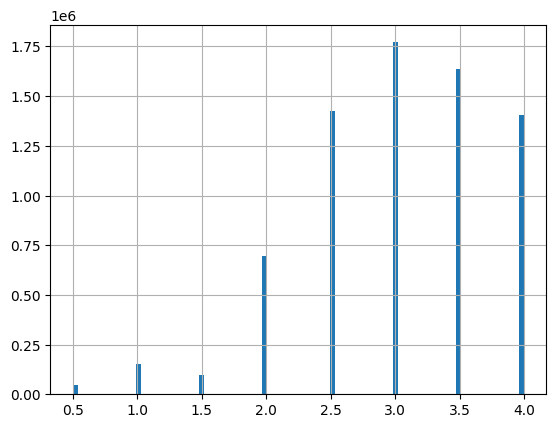

In [19]:
#plot the distribution fo N
scaled_coincidences_df['N'].hist(bins=100)
scaled_coincidences_df['N'].describe()


In [20]:
# average N
np.average(scaled_coincidences_df["N"])

np.float64(3.0332571872730973)

In [21]:
scaled_coincidences_df[scaled_coincidences_df["repetition"] == 9400]

,data_dir,repetition,C,DB_H,DB_V,SB,N
9400,2025-06-03--11h-02m-55s,9400,0.0,4.0,0.0,0.0,4.0
83657,2025-06-03--11h-04m-33s,9400,0.0,4.0,0.0,0.0,4.0
157066,2025-06-03--11h-05m-58s,9400,0.0,4.0,0.0,0.0,4.0
232174,2025-06-03--11h-07m-21s,9400,0.0,4.0,0.0,0.0,4.0
308969,2025-06-03--11h-08m-43s,9400,0.0,3.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...
6764693,2025-06-03--12h-58m-28s,9400,0.5,1.0,2.0,0.0,3.5
6858421,2025-06-03--12h-59m-52s,9400,1.5,0.0,1.0,0.0,2.5
6954149,2025-06-03--13h-01m-14s,9400,0.0,3.0,1.0,0.0,4.0
7048890,2025-06-03--13h-02m-38s,9400,1.0,1.0,1.0,0.0,3.0


In [ ]:
chunks = []
target_N = 40

# Group the DataFrame by 'data_dir'
for data_dir, group_df in scaled_coincidences_df.groupby('data_dir'):
    group_df = group_df.reset_index(drop=True)
    N_values = group_df['N'].values
    used = np.zeros(len(group_df), dtype=bool)

    while True:
        current_indices = []
        current_sum = 0
        made_progress = False

        for i in range(len(N_values)):
            if used[i]:
                continue

            n_val = N_values[i]
            if current_sum + n_val > target_N + 0.5:
                continue

            current_indices.append(i)
            current_sum += n_val
            used[i] = True
            made_progress = True

            # Accept if sum is within [target_N - 1, target_N + 1]
            if target_N - 0.5 <= current_sum <= target_N + 0.5:
                chunk_df = group_df.iloc[current_indices]
                chunks.append(chunk_df)
                break

        if not (target_N - 0.5 <= current_sum <= target_N + 0.5):
            # Undo used marking
            used[current_indices] = False

        if not made_progress or not (target_N - 0.5 <= current_sum <= target_N + 0.5):
            break

# Summarize chunks
chunk_summaries = []

for chunk in chunks:
    summary = chunk.sum(numeric_only=True)
    summary['data_dir'] = chunk['data_dir'].iloc[0]
    chunk_summaries.append(summary)

# Combine all summaries into a DataFrame
result_df = pd.DataFrame(chunk_summaries)

# Drop the 'repetition' column if it exists
result_df = result_df.drop(columns=['repetition'], errors='ignore')

# Reorder columns
cols = ['data_dir'] + [col for col in result_df.columns if col != 'data_dir']
result_df = result_df[cols]

result_df


KeyboardInterrupt: 

In [ ]:
# save the dataframes to csv files based on the data_dir
for data_dir in new_data_dirs:
    df_subset = result_df[result_df["data_dir"] == data_dir]
    if not df_subset.empty:
        output_file = os.path.join(data_folder, data_dir, "chunked_coincidences_n=40.csv")
        df_subset.to_csv(output_file, index=False)
        print(f"Saved {output_file}")

Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-06-02--17h-06m-16s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-06-02--17h-07m-37s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-06-02--17h-07m-47s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-06-02--17h-07m-56s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-06-02--17h-08m-05s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/R